In [24]:
import chainer
from PIL import Image, ImageDraw, ImageFont, ImageOps
import csv
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import imutils
import easyocr
from manga_ocr import MangaOcr
from scipy.ndimage import rotate
from imutils.contours import sort_contours

import sys
sys.path.append('../../')

from kr.detector.centernet.resnet import Res18UnetCenterNet
from kr.classifier.softmax.mobilenetv3 import MobileNetV3
from kr.datasets import KuzushijiUnicodeMapping

/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg
(2763, 4408)


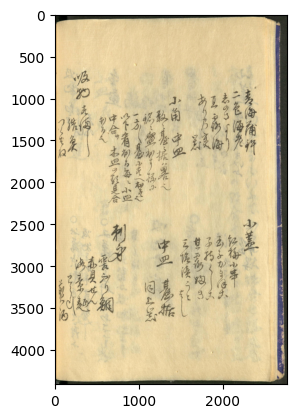

In [176]:
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'
filename = '/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/brsk00000/images/brsk001_005.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200014685/images/200014685_00002_2.jpg'
# --> filename = '/home/ec2-user/code/restor-ai-tion/data/full/200004148/images/200004148_00002_2.jpg'
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/image2.png'
# inverted_filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/invertedimage2.png'
# image = Image.open(filename)
# inverted_image = ImageOps.invert(image)
# inverted_image.save(inverted_filename)
# filename = inverted_filename
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/e6eeb23552e1a21c.png'
print(filename)
image = Image.open(filename)
# img1 = image.resize((640, 640))
# img1.save('/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/t.png')
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/t.png'
plt.imshow(image, cmap='gray')
print(image.size)
plt.show()



In [177]:
def predict(detector_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/detector/model_700.npz',
            classifier_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/classifier/model_1000.npz',
            image_filename='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'):

    # unicode <-> unicode index mapping
    mapping = KuzushijiUnicodeMapping()
    
    # load trained detector
    detector = Res18UnetCenterNet()
    chainer.serializers.load_npz(detector_model, detector)
    
    # load trained classifier
    classifier = MobileNetV3(out_ch=len(mapping))
    chainer.serializers.load_npz(classifier_model, classifier)
    
    # load image
    image = Image.open(image_filename)
    
    # character detection
    bboxes, bbox_scores = detector.detect(image)
    
    # character classification
    unicode_indices, scores = classifier.classify(image, bboxes)
    unicodes = [mapping.index_to_unicode(idx) for idx in unicode_indices]
    return unicodes, scores, bboxes, bbox_scores

In [178]:
unicodes, unicode_scores, bboxes, bbox_scores = predict(image_filename=filename)
for uc, bb in zip(unicodes, bboxes):
    label = chr(int(uc[2:], 16))
    print(uc, label, bb)

U+8C9D 貝 [ 394.80764403 3044.74339215  488.69771711 3207.28011631]
U+304B か [1932.93604157 2933.07716693 2034.45340703 3025.30722927]
U+6D77 海 [2258.47682269 1101.07238683 2403.27438327 1248.59166359]
U+307B ほ [1928.12804984 3145.49635048 2050.05609751 3271.17313698]
U+6F2C 漬 [1504.01820778 2991.85044061 1611.60913282 3145.69466226]
U+985E 類 [ 659.08348693 1908.81042221  761.4761925  2031.6903512 ]
U+3053 こ [1937.09843441 3275.57588636 2058.1411847  3395.5336642 ]
U+8D64 赤 [ 390.49027617 2883.88736469  500.10399607 3042.1862007 ]
U+6D77 海 [2118.79960807 1260.46673955 2249.08542646 1415.91957977]
U+4E8C 二 [2108.74024434  917.42843986 2204.80388381 1003.17356954]
U+6D77 海 [ 243.02755977 2899.41277897  360.0334868  3077.23478875]
U+5B50 子 [1785.51538426 2653.85228853 1866.35346198 2786.55937337]
U+8272 色 [2119.2771642  1040.39968166 2220.75216694 1204.52978563]
U+51FA 出 [ 788.86133383 1604.31397246  893.20799483 1719.67366856]
U+307E ま [ 278.14978908 1219.18091079  426.31791011 1402.31651

In [179]:
font_path = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf'
font = ImageFont.truetype(font_path, 50, encoding='utf-8')
text_color = 'rgb(255, 0, 0)'
true_color = 'rgb(0, 0, 255)'

def bbox_values(bbox):
    divisor = 1
    return int(bbox[0]/divisor), int(bbox[1]/divisor), int(bbox[2]/divisor), int(bbox[3]/divisor)

def visualize_preds(orig_filename, unicodes, unicode_scores, bboxes, bbox_scores, 
                    limit=-1,
                    verbose=False,
                    full_dataset='/home/ec2-user/code/restor-ai-tion/data/full',
                    same_image=True,
                    save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    orig_img = Image.open(orig_filename)
    pred_img = Image.open(orig_filename)
    true_img = Image.open(orig_filename)
    pred_draw = ImageDraw.Draw(pred_img)
    true_draw = ImageDraw.Draw(true_img)
    if limit == -1:
        limit = len(unicodes)
    print('limit', limit)

    for (pred, uscore, bbox, bscore) in zip(unicodes[:limit], unicode_scores[:limit], bboxes[:limit], bbox_scores[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        if verbose:
            print('!!!', pred, label, uscore, x, y, w, h, bscore)

        
        pred_draw.text((x - 50, y - 10), label, fill=text_color, font = font)
        # pred_draw.rectangle([(x, y), (w, h)], outline='blue', width=3)


    x = os.path.basename(orig_filename).replace('-', '_')
    true_image_available = False

    num_correct = 0
    num_wrong = 0

    print(x)
    
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookanme = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

        image_name = x.split('.')[0]
        csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
        print(csv_file)
        true_unicodes = []
        true_bboxes = []
        with open(csv_file) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Image'] == image_name:
                    uc = row['Unicode']
                    true_unicodes.append(chr(int(uc[2:], 16)))
                    true_bboxes.append([int(row['X']), int(row['Y']), int(row['Width']), int(row['Height'])])

        print(len(true_unicodes), len(unicodes))
        total = len(true_unicodes)

        if same_image:
            dimg = pred_draw
        else:
            dimg = true_draw
        for (uc, bbox) in zip(true_unicodes, true_bboxes):
            x, y, w, h = bbox_values(bbox)
            w = w + x
            h = h + y
            if verbose:
                print('>', pred, label, uscore, x, y, w, h, bscore)
    
            
            dimg.text((x + 100, y - 10), uc, fill=true_color, font = font)
            # dimg.rectangle([(x, y), (w, h)], outline='green', width=4)  
            found_char = False
            for (pred, pbbox) in zip(unicodes[:limit], bboxes[:limit]):
                # if abs(xpred - x) < 200.0 and abs(ypred - y) < 200.0 and cpred == char:
                xpred, ypred, width, height = bbox_values(pbbox)
                puc = chr(int(pred[2:], 16))
                if abs(xpred - x) < 200 and abs(ypred - y) < 200 and puc == uc:
                    found_char = True
                    break
            if found_char:
                num_correct += 1
            else:
                num_wrong += 1

        print('accuracy', total, (num_correct*1.0/total), (num_wrong*1.0)/total)

    if same_image or not true_image_available:
        plt.figure()
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        basename = os.path.basename(orig_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_filename]
    else:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(true_img)
        plt.title('True')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        
        basename = os.path.basename(orig_filename)
        save_true_filename = os.path.join(save_folder, 'true_{}'.format(basename))
        true_img.save(save_true_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_true_filename, save_filename]

    return viz_filenames


limit 130
200021763_00016_1.jpg
/home/ec2-user/code/restor-ai-tion/data/full/200021763/200021763_coordinate.csv
135 130
accuracy 135 0.8518518518518519 0.14814814814814814


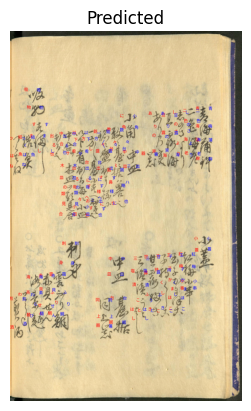

In [180]:
pred_filenames = visualize_preds(filename,
                                 unicodes, unicode_scores, bboxes, bbox_scores, 
                                 same_image=True,
                                 limit=-1, verbose=False)
pred_filename = pred_filenames[0]

In [181]:
# clustering of bounding boxes
clustering_data = []
for uc, box in zip(unicodes, bboxes):
    x, y, w, h = box
    clustering_data.append([x, y, uc])
clustering_df = pd.DataFrame(clustering_data, columns=['X', 'Y', 'Char'])
clustering_df

,X,Y,Char
0,394.807644,3044.743392,U+8C9D
1,1932.936042,2933.077167,U+304B
2,2258.476823,1101.072387,U+6D77
3,1928.128050,3145.496350,U+307B
4,1504.018208,2991.850441,U+6F2C
...,...,...,...
125,1133.260872,1322.375707,U+3005
126,987.125825,1372.985510,U+3057
127,1550.243637,3175.866661,U+3053
128,713.678230,1426.302994,U+30B5


In [182]:
# pyclustering with custom distance metric
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.utils.metric import type_metric, distance_metric

def py_clusters(data, imx, imy, n_clusters=8):
    bx = list(data['X'])
    by = list(data['Y'])
    bxy = list(zip(bx,by))

    user_function = lambda point1, point2: abs(point1[1] - point2[1]) + abs(point1[0] - point2[0]) * 10
    metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
    
    # create K-Means algorithm with specific distance metric
    start_centers = []
    column_size = imx / n_clusters
    offset = column_size/2
    for cid in range(n_clusters):
        start_centers.append([offset+(cid*column_size), imy/2])
    print(start_centers)
    kmeans_instance = kmeans(bxy, start_centers, metric=metric)
    
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()

    cluster_fig = kmeans_visualizer.show_clusters(bxy, kmeans_instance.get_clusters(), kmeans_instance.get_centers())
    cluster_fig.savefig('data/preds/clusters_{}'.format(os.path.basename(filename)))
    cluster_fig.show()


    return kmeans_instance

[[69.075, 2204.0], [207.22500000000002, 2204.0], [345.375, 2204.0], [483.52500000000003, 2204.0], [621.6750000000001, 2204.0], [759.825, 2204.0], [897.9750000000001, 2204.0], [1036.125, 2204.0], [1174.275, 2204.0], [1312.4250000000002, 2204.0], [1450.575, 2204.0], [1588.7250000000001, 2204.0], [1726.8750000000002, 2204.0], [1865.025, 2204.0], [2003.1750000000002, 2204.0], [2141.325, 2204.0], [2279.475, 2204.0], [2417.625, 2204.0], [2555.775, 2204.0], [2693.9249999999997, 2204.0]]


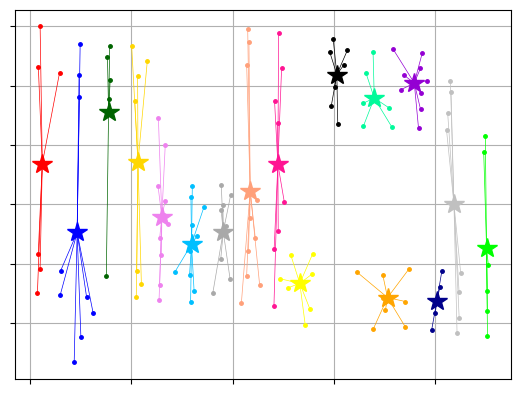

In [183]:
k = py_clusters(clustering_df, image.size[0], image.size[1], n_clusters=20)

In [184]:
clusters = k.get_clusters()
reading_order_list = []
n = len(clusters)

for _ in range(n):
    reading_order_list.append([])

print(len(reading_order_list), n)

for cid in range(n):
    pts = [[clustering_df['X'][row], clustering_df['Y'][row], clustering_df['Char'][row]] for row in clusters[cid]]
    s_pts = sorted(pts, key=lambda pt: pt[1])
    reading_order_list[n-1-cid] = s_pts

phrase = []
for col in reading_order_list:
    for c in col:
        x = c[2]
        phrase.append(chr(int(x[2:], 16)))
' '.join(phrase)

17 17


'青 海 蒲 鉾 小 蓋 二 色 海 老 紅 梅 小 事 し の さ よ り 玉 子 か く ま し ほ こ こ あ 豆 り 露 の 実 器 海 子 世 持 露 ふ き 三 塩 漬 こ は と し に 角 々 台 中 〻 皿 教 据 鼻 也 中 皿 台 据 銘 々 盛 出 す 様 に 同 上 器 方 し 台 に す へ お す 也 以 下 肴 サ 出 る 毎 々 小 皿 中 合 木 皿 の 類 見 合 刺 身 出 る 也 霊 ふ り 鯛 し 赤 貝 せ ん 吸 物 す ま 結 魚 海 茶 麺 つ は ね わ 煎 酒'

In [185]:
def get_true_phrase(filename, full_dataset='/home/ec2-user/code/restor-ai-tion/data/full'):
    x = os.path.basename(filename).replace('-', '_')
    true_image_available = False

    num_correct = 0
    num_wrong = 0

    # print(x)
    
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookname = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

    image_name = x.split('.')[0]
    csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
    # print(csv_file)
    true_unicodes = []
    with open(csv_file) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['Image'] == image_name:
                uc = row['Unicode']
                char_id = row['Char ID']
                true_unicodes.append([chr(int(uc[2:], 16)), char_id])

    true_phrase = [x[0] for x in true_unicodes]
    return true_phrase

In [186]:
true_phrase = get_true_phrase(filename)
print('true', ' '.join(true_phrase))
print('pred', ' '.join(phrase))

print(len(true_phrase), len(phrase))

true 青 梅 蒲 鉾 二 色 海 老 し の さ よ り 豆 露 海 あ り の 実 箸 小 角 中 皿 数 々 台 ニ 据 ハ 略 也 銘 々 盛 出 す 様 に 一 方 〱 台 に す へ 出 す 也 以 下 肴 出 る 毎 ニ 小 皿 中 合 サ 木 皿 の 類 見 合 出 る 也 吸 物 す ま し 結 魚 つ く は ね 小 蓋 紅 梅 小 串 玉 子 か ま ほ こ 子 持 く し こ 甘 露 ふ き 三 塩 漬 う と は し 中 皿 台 据 同 上 箸 刺 身 霜 ふ り 鯛 赤 貝 せ ん 海 素 麺 わ ら び 煎 酒
pred 青 海 蒲 鉾 小 蓋 二 色 海 老 紅 梅 小 事 し の さ よ り 玉 子 か く ま し ほ こ こ あ 豆 り 露 の 実 器 海 子 世 持 露 ふ き 三 塩 漬 こ は と し に 角 々 台 中 〻 皿 教 据 鼻 也 中 皿 台 据 銘 々 盛 出 す 様 に 同 上 器 方 し 台 に す へ お す 也 以 下 肴 サ 出 る 毎 々 小 皿 中 合 木 皿 の 類 見 合 刺 身 出 る 也 霊 ふ り 鯛 し 赤 貝 せ ん 吸 物 す ま 結 魚 海 茶 麺 つ は ね わ 煎 酒
135 130


In [104]:
k.get_centers()

[[109.66697043702008, 1649.356459298736],
 [352.7751321824636, 1578.3311106909314],
 [594.1516420369825, 1128.3262311763312],
 [605.2407946671349, 2425.14639712068],
 [841.7656902348766, 1618.2028761468164],
 [1084.7826113443052, 1696.9759261598247],
 [1329.2888542602304, 1041.80185996456],
 [1329.4791332422703, 2297.4598043107458],
 [1564.7200467912842, 1697.9807930805368],
 [1802.4400860174344, 809.7620860928625]]

In [32]:
' '.join([chr(int(c[2:], 16)) for c in unicodes])

'元 也 士 之 八 十 八 氏 于 州 以 略 之 平 八 氏 之 説 良 以 八 大 是 八 勇 見 八 大 於 与 忠 臣 有 初 世 魂 伝 二 臣 筆 谷 士 登 義 皿 称 足 不 惜 英 同 也 於 因 載 堅 安 家 其 雖 徳 宜 考 記 見 如 房 為 冠 総 伝 宇 人 胆 為 以 其 衆 当 百 里 将 年 姓 哉 談 至 唯 僅 春 権 時 名 序 今 卒 大 損 時 軍 希 坊 姓 虞 無 者 識 当 顛 威 楠 其'

In [8]:
def get_text(chars, boxes, limit=-1):
    if limit == -1:
        limit = len(chars)

    ubox_tuples = [(chr(int(c[2:], 16)), bbox_values(box)) for (c, box) in zip(chars[:limit], boxes[:limit])]
    print(ubox_tuples)

In [9]:
get_text(unicodes, bboxes, limit=10)

[('元', (593, 654, 748, 757)), ('也', (1560, 1959, 1713, 2066)), ('士', (1803, 798, 1939, 893)), ('之', (846, 1305, 994, 1403)), ('八', (1091, 2450, 1234, 2520)), ('十', (1334, 2282, 1463, 2392)), ('八', (589, 513, 741, 585)), ('氏', (103, 494, 236, 614)), ('于', (1339, 2115, 1456, 2231)), ('州', (1082, 506, 1203, 602))]


In [10]:
int_boxes = np.array([bbox_values(b) for b in bboxes[:10]])
print(int_boxes)

[[ 593  654  748  757]
 [1560 1959 1713 2066]
 [1803  798 1939  893]
 [ 846 1305  994 1403]
 [1091 2450 1234 2520]
 [1334 2282 1463 2392]
 [ 589  513  741  585]
 [ 103  494  236  614]
 [1339 2115 1456 2231]
 [1082  506 1203  602]]


In [11]:
def bbox_values2(bbox):
    divisor = 1
    b = bbox/divisor
    return int(b[0]), int(b[1]), int(abs(b[0]-b[2])), int(abs(b[1]-b[3]))

def get_unicode(uc):
    return [chr(int(c[2:],16)) for c in uc]

scaled_bboxes = [bbox_values2(b) for b in bboxes]



print(scaled_bboxes[:10])
print(' '.join(get_unicode(unicodes)))


# uc = [chr(int(c[2:], 16)) for c in unicodes]
# tb = list(zip(*sorted(zip(uc, scaled_bboxes), key=lambda b: -b[1][0]+b[1][1], reverse=False)))
# print(' '.join(list(tb)[0]))
# for i in range(10):
#     print(tb[0][i], tb[1][i])
# # rl = list(zip(*sorted(zip(*tb), key=lambda b: b[1][1], reverse=False)))
# # print(' '.join(list(rl)[0]))
# # print(rl[0][0], tb[1][0])
# # print(rl[0][1], rl[1][1])

# arr = np.array(bboxes)
# r = (arr[:, 0]**2 + arr[:, 1] **2)**0.5
# indices = np.argsort(r)
# print(indices)
# ordered_chars = []
# for i in indices:
#     c = unicodes[i]
#     ordered_chars.append(chr(int(c[2:], 16)))
# print(ordered_chars)



[(593, 654, 155, 102), (1560, 1959, 153, 107), (1803, 798, 135, 95), (846, 1305, 147, 97), (1091, 2450, 142, 70), (1334, 2282, 128, 110), (589, 513, 151, 71), (103, 494, 132, 120), (1339, 2115, 116, 115), (1082, 506, 120, 95)]
元 也 士 之 八 十 八 氏 于 州 以 略 之 平 八 氏 之 説 良 以 八 大 是 八 勇 見 八 大 於 与 忠 臣 有 初 世 魂 伝 二 臣 筆 谷 士 登 義 皿 称 足 不 惜 英 同 也 於 因 載 堅 安 家 其 雖 徳 宜 考 記 見 如 房 為 冠 総 伝 宇 人 胆 為 以 其 衆 当 百 里 将 年 姓 哉 談 至 唯 僅 春 権 時 名 序 今 卒 大 損 時 軍 希 坊 姓 虞 無 者 識 当 顛 威 楠 其


In [12]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, [5, 5], 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts[:2]
# cv2.boundingRect(cnts[0])
# cnts = imutils.contours.sort_contours(cnts, method='left-to-right')[0]
# print(cnts[:1])

(array([[[ 691, 3212]],
 
        [[ 690, 3213]],
 
        [[ 690, 3214]],
 
        [[ 688, 3216]],
 
        [[ 672, 3216]],
 
        [[ 671, 3217]],
 
        [[ 670, 3216]],
 
        [[ 663, 3216]],
 
        [[ 662, 3215]],
 
        [[ 660, 3215]],
 
        [[ 659, 3216]],
 
        [[ 658, 3216]],
 
        [[ 656, 3218]],
 
        [[ 650, 3218]],
 
        [[ 649, 3217]],
 
        [[ 646, 3217]],
 
        [[ 643, 3214]],
 
        [[ 644, 3215]],
 
        [[ 644, 3216]],
 
        [[ 645, 3216]],
 
        [[ 646, 3217]],
 
        [[ 649, 3217]],
 
        [[ 650, 3218]],
 
        [[ 656, 3218]],
 
        [[ 658, 3216]],
 
        [[ 659, 3216]],
 
        [[ 660, 3215]],
 
        [[ 662, 3215]],
 
        [[ 663, 3216]],
 
        [[ 670, 3216]],
 
        [[ 671, 3217]],
 
        [[ 672, 3216]],
 
        [[ 688, 3216]],
 
        [[ 689, 3217]],
 
        [[ 710, 3217]],
 
        [[ 711, 3216]],
 
        [[ 713, 3216]],
 
        [[ 714, 3217]],
 
        [[ 7

In [13]:
def ocr_image(tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds',
                    image_filename=filename):
    # new image attempt.
    tgt_filename = os.path.join(tgt_folder, 'ocr_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))
    pred_draw = ImageDraw.Draw(pred_image)
    limit = len(unicodes)
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_draw.text((x-20, y-10), label, fill=text_color, font = font)
    pred_image.save(tgt_filename)    
    
    ocr_img = cv2.imread(tgt_filename)
    plt.imshow(ocr_img)
    return tgt_filename

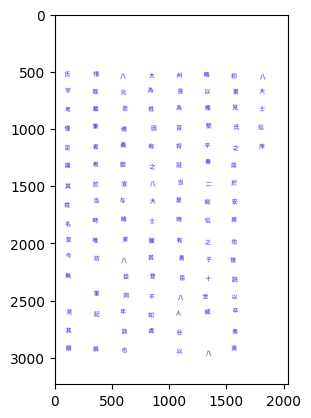

In [14]:
ocr_filename = ocr_image(image_filename=filename)

In [15]:
def easyocr_prediction(ocr_filename, detail=0):
    ## easyocr on modern japenese
    reader = easyocr.Reader(['ja'])
    result = reader.readtext(ocr_filename, detail = detail)
    return result

In [16]:
result = easyocr_prediction(pred_filename, detail=0)
' '.join(result)

"つ 川龍トドが [噌平プ和[` ダ [学 〔 舞[夏ト}野国力犬 考 里 【考 さ為 美推尾見井士 1末 摩舞 ~〈魂:   百 鷺 壁 講 義 将 井 逸  籍 舞 冠 殺 慶芸 謙穂里腰 之一 が対越 良通宜 {いに う 当 愚 トニニ於二 継 内' 尚 姓エ ど[舞鷲 楠 予, 鶏 上# 臣 垂範離 際操 倒 1,  無撫| 匡臣臣貨  医国十ジ適 田 事同同 不 [孫トい#増 以 見 艶聖 如 ※1気 際 #龍 変龍談 簾 名 破 際 朝道糞 損祥 世ュ 舞以ソ 元  メ 英き 牛ざ"

In [17]:
# manga-ocr
def mangaocr_prediction(tgt_filename):
    mocr = MangaOcr()
    text = mocr(tgt_filename)
    return text

In [18]:
text = mangaocr_prediction(pred_filename)
print(text)

2023-10-24 00:07:23.313 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2023-10-24 00:07:25.403016: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 00:07:25.403057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 00:07:25.410403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 00:07:25.888175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other opera

べギ俺ゲヰゲベカべカべえタだねぇぇぇにゃにゃへへへハへへーよぬホっぷりぺトよぷルぢゃダカヰセカオオヤヘヘヘぐぷみヰげオべへへごぼぷぷぷっごぼぼぷはぷぷにぷがぷってぷぷはぺぷにゃぷはゑやぁあああやああがぷやあやぁぁぁあやめみやあぁあ


In [19]:
# new image (rotated) attempt.
def rot(dim_orig, dim_rot, xy, angle=90):
    org_center = (np.array(dim_orig[:2][::-1])-1)/2.
    rot_center = (np.array(dim_rot[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return new+rot_center

def rotate_image(image_filename, ocr_filename, tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    tgt_rot_filename = os.path.join(tgt_folder, 'ocr_rotated_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(image_filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_rot_image = Image.new('RGB', (n, m), color=(255,255,255,127))
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))

    pred_draw = ImageDraw.Draw(pred_image)
    pred_rot_draw = ImageDraw.Draw(pred_rot_image)
    limit = len(unicodes)
    
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        xr, yr = rot((n, m), (m, n), (x,y))
        # print(x, y, xr, yr)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_rot_draw.text((xr, yr), label, fill=text_color, font = font)

    pred_rot_image.save(tgt_rot_filename)    
    
    return tgt_rot_filename

def vizualize_ocrs(ocr_filename, ocr_rot_filename):
    ocr_image = cv2.imread(ocr_filename)
    ocr_rot_image = cv2.imread(ocr_rot_filename)
    
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    plt.imshow(ocr_image)
    plt.title('regular')
    
    plt.subplot(1,2,2)
    plt.imshow(ocr_rot_image)
    plt.title('rotated by 90')
    plt.show()

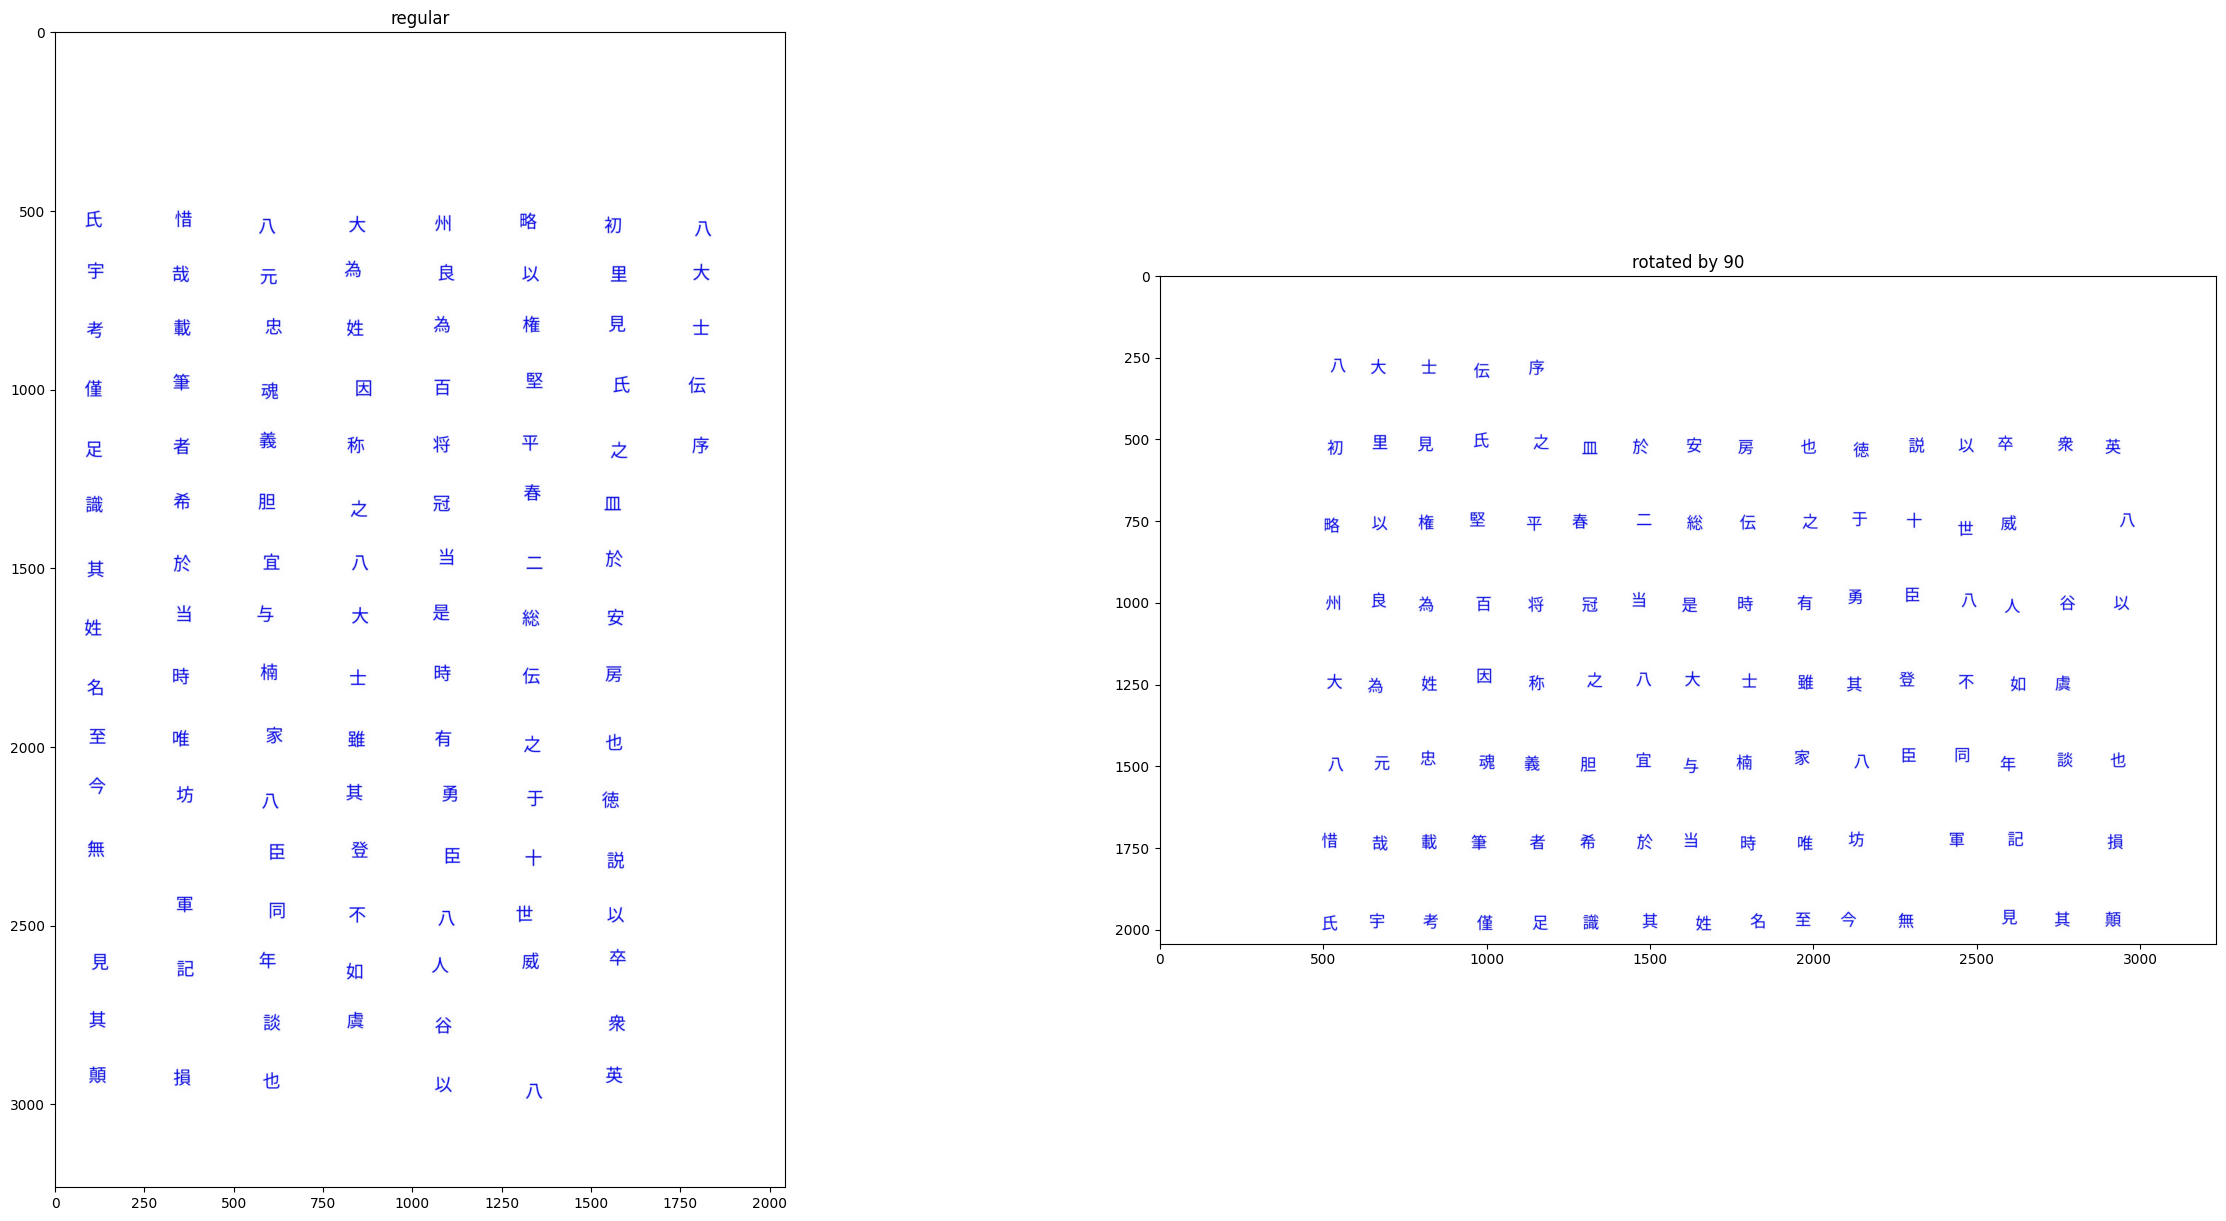

In [20]:
ocr_rot_filename = rotate_image(filename, ocr_filename)
vizualize_ocrs(ocr_filename, ocr_rot_filename)

In [21]:
result = easyocr_prediction(ocr_rot_filename, detail=1)
s = []
for x in result:
    s.append(x[1])
''.join(s)

'八大士澤伝澤序初 里見澤氏澤 之皿澤於澤安澤房澤也澤徳澤説澤以 卒澤 衆澤英略澤以権澤堅澤平莉春澤 二澤総澤伝澤 之手 +世威州 良為澤百将澤冠当 是澤時有 勇澤臣澤八 人澤谷澤以大 為  姓因称澤 之八 大澤士澤 雛其澤 登不澤如澤慶八澤元 忠澤 魂義澤肥澤宜与 楠澤 家澤八莉臣澤同 年澤 談澤 也借澤 哉 載 筆者澤希澤 於澤莉当   時 唯澤 坊軍 記損氏宇 考澤偉澤 足澤 識澤其澤姓名 至今  無見澤其澤 連'

In [22]:
text = mangaocr_prediction(ocr_rot_filename)
print(text)

2023-10-24 00:07:40.437 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
/home/ec2-user/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2023-10-24 00:07:42.327 | INFO     | manga_ocr.ocr:__init__:19 - Using CUDA
2023-10-24 00:07:42.512 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


そして、このようなことをしていましたが、これからの人がいるのですが、それではないと思います。それはそういうことができませんでしょう。
